In [3]:
# STEP 1: Data Import & Cleaning

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats

In [42]:
# Read file
# df = read csv ( owid climate data)
# Check for missing data
# df with temp = countrys with temp anonomalys
# df region = seperate regions
# df countrys = seperate countrys
# So i can choose wich variable i would like to explore within the data

df = pd.read_csv("owid_climate_data.csv") # df becomes the variable that holds the data, i didnt name it data because that could cause future conflicts 

print("Original shape:", df.shape)
print("Columns:", df.columns.tolist())


Original shape: (26182, 5)
Columns: ['Country Name', 'Country Code', 'Year', 'CO2 Emissions Per Capita', 'Annual Temperature Anomaly']


In [5]:
# Check for missing values
print("\nMissing values check:")
print(df.isnull().sum())


Missing values check:
Country Name                      0
Country Code                   3287
Year                              0
CO2 Emissions Per Capita          0
Annual Temperature Anomaly    11863
dtype: int64


In [6]:
# First cleaning: Remove missing values and create the df variable i will use to create more variables later on
df = df.dropna(subset=["CO2 Emissions Per Capita", "Annual Temperature Anomaly"])
print("After removing missing values:", df.shape)

After removing missing values: (14319, 5)


In [7]:
# Standardize country names and make sure the strings are clean
df["Country Name"] = df["Country Name"].str.strip().str.title()

In [8]:
# make sure the number fields are clean
df["CO2 Emissions Per Capita"] = pd.to_numeric(df["CO2 Emissions Per Capita"], errors="coerce")
df["Annual Temperature Anomaly"] = pd.to_numeric(df["Annual Temperature Anomaly"], errors="coerce")

In [9]:
# Check the CO2 range
#364 seems absurdly high and coule be a blemish in the data
print("CO2 range:", df["CO2 Emissions Per Capita"].min(), "to", df["CO2 Emissions Per Capita"].max())


CO2 range: 0.0 to 364.6994


In [10]:
# Count values over 100

over_100 = df[df["CO2 Emissions Per Capita"] > 100]
print(f"Records with CO2 > 100: {len(over_100)}")

Records with CO2 > 100: 5


In [11]:
# Checking the largest 10 co2 per capita years in the data
# as suspected there are multiple entrys with large ammounts that dont fit the known averages.
# Kuwait was invaded in 1991 so the data from this year could be an outlier because of this

top_co2 = df.nlargest(10, "CO2 Emissions Per Capita")
print(top_co2[["Country Name", "Year", "CO2 Emissions Per Capita"]])


               Country Name  Year  CO2 Emissions Per Capita
13092                Kuwait  1991                364.699400
3717                 Brunei  1949                245.081000
19494                 Qatar  1963                121.810740
3715                 Brunei  1947                117.805984
19495                 Qatar  1964                110.291940
19496                 Qatar  1965                 98.179634
19497                 Qatar  1966                 86.928604
24415  United Arab Emirates  1969                 85.580185
19498                 Qatar  1967                 82.083250
19499                 Qatar  1968                 77.138950


In [13]:
# Count how many entries over 50

over_50 = df[df["CO2 Emissions Per Capita"] > 50]
print(f"Records with CO2 > 50: {len(over_50)}")

Records with CO2 > 50: 53


In [14]:
#show the results of countrys with over 50 tonne co2 emmisions per capita

print(over_50[["Country Name", "Year", "CO2 Emissions Per Capita"]].to_string())

               Country Name  Year  CO2 Emissions Per Capita
3708                 Brunei  1940                 70.417960
3712                 Brunei  1944                 56.461067
3715                 Brunei  1947                117.805984
3717                 Brunei  1949                245.081000
3738                 Brunei  1970                 60.720894
3739                 Brunei  1971                 54.478725
3740                 Brunei  1972                 66.501490
3741                 Brunei  1973                 67.689750
3742                 Brunei  1974                 53.587190
3746                 Brunei  1978                 54.524246
13065                Kuwait  1964                 53.510590
13066                Kuwait  1965                 67.909400
13067                Kuwait  1966                 61.345150
13092                Kuwait  1991                364.699400
19494                 Qatar  1963                121.810740
19495                 Qatar  1964       

In [15]:
df_with_temps = df[df["Year"] >= 1940].copy()

In [16]:
print("df_with_temps size:", df_with_temps.shape)

df_with_temps size: (14319, 5)


In [17]:
# Load the original uncleaned data to see regions
original_df = pd.read_csv('owid_climate_data.csv')

# Now find regions (entries without country codes)
regions = original_df[original_df['Country Code'].isnull()]['Country Name'].unique()
print(f"Found {len(regions)} regions/aggregations:")
print(regions)

Found 16 regions/aggregations:
['Africa' 'Asia' 'Asia (excl. China and India)' 'Europe'
 'Europe (excl. EU-27)' 'Europe (excl. EU-28)' 'European Union (27)'
 'European Union (28)' 'High-income countries' 'Low-income countries'
 'Lower-middle-income countries' 'North America'
 'North America (excl. USA)' 'Oceania' 'South America'
 'Upper-middle-income countries']


In [18]:
# Create df_regions (only regional groupings)
regions = ["World", "Africa", "Asia", "Europe", "North America", "South America", 
           "Oceania", "High-Income Countries", "Low-Income Countries", 
           "Middle-Income Countries", "European Union", "Upper-Middle-Income Countries",
           "Lower-Middle-Income Countries"]


In [19]:
# Add entries that contain "income" or other regional indicators
region_mask = df["Country Name"].isin(regions) | df["Country Name"].str.contains("income|Union|excl", case=False, na=False) # create mask that  we will use to get rid of regions from out new df_countries variable
df_regions = df[region_mask].copy() #apply that mask to df_regions to make it its own variable aswell incase i want to explore it
print("df_regions size:", df_regions.shape)

# Create df_countries (only actual countries)
print("\nCreating df_countries")
df_countries = df[~region_mask].copy() # use the mask we created earlier to create df_countries wich is only countries.
print("df_countries size:", df_countries.shape)

df_regions size: (75, 5)

Creating df_countries...
df_countries size: (14244, 5)


In [43]:
major_economies = [   # here i am creating the major_economies variable that will be used later on
    "Australia", "Brazil", "China", "India", "Germany",
    "South Africa", "United States", "Canada", "Indonesia", "United Kingdom"
]

In [55]:
# STEP 2: Sets & Functions  
# Create set of all countries
countries = set(df_countries["Country Name"])  # making the variable we created earlier into a set called countries
print("Number of actual countries:", len(countries))



Number of actual countries: 186


In [22]:
# Function to get rows for a specific country and year range
def get_country_data(df, country, start_year, end_year):
    # Filter the DataFrame by country and year range
    filtered = df[(df["Country Name"] == country) & 
                  (df["Year"] >= start_year) & 
                  (df["Year"] <= end_year)]
    return filtered

In [23]:
# Test function with countries dataframe
Aus_data = get_country_data(df_countries, "Australia", 2000, 2020)
print("Australia data 2000-2020:", len(Aus_data), "rows")
print(Aus_data.head(22))

Australia data 2000-2020: 21 rows
     Country Name Country Code  Year  CO2 Emissions Per Capita  \
1709    Australia          AUS  2000                 18.293966   
1710    Australia          AUS  2001                 18.475426   
1711    Australia          AUS  2002                 18.501194   
1712    Australia          AUS  2003                 18.649893   
1713    Australia          AUS  2004                 19.113388   
1714    Australia          AUS  2005                 19.028670   
1715    Australia          AUS  2006                 19.055374   
1716    Australia          AUS  2007                 19.063927   
1717    Australia          AUS  2008                 18.943853   
1718    Australia          AUS  2009                 18.688644   
1719    Australia          AUS  2010                 18.297338   
1720    Australia          AUS  2011                 17.965439   
1721    Australia          AUS  2012                 17.774640   
1722    Australia          AUS  2013      

In [24]:
# STEP 3: Logical Filtering
# Filter the DataFrame to keep only rows where:
# Year is 2020
# CO2 emissions are greater than 10 metric tons per capita
# We use df_countries so that regions and world totals are excluded.

#high co2  = df countries(year) == 2020 & df countries(co2 emmissions per capita > 10)
high_co2 = df_countries[(df_countries["Year"] == 2020) & (df_countries["CO2 Emissions Per Capita"] > 10)]

# Printin a heading so the output is clearer
print("Countries with CO2 > 10 in 2020:")

# Select and display only the relvant columns for easier reading
result = high_co2[["Country Name", "CO2 Emissions Per Capita", "Annual Temperature Anomaly"]]
print(result) #output the filtered table


Countries with CO2 > 10 in 2020:
               Country Name  CO2 Emissions Per Capita  \
1729              Australia                 15.506062   
2272                Bahrain                 25.215979   
3788                 Brunei                 24.939121   
4447                 Canada                 13.795024   
8826          Faroe Islands                 14.426020   
12876            Kazakhstan                 13.113933   
13121                Kuwait                 21.739220   
14411            Luxembourg                 12.806264   
15578              Mongolia                 11.265909   
16476         New Caledonia                 17.981370   
18307                  Oman                 15.174401   
19551                 Qatar                 36.564110   
19889                Russia                 11.156080   
20538          Saudi Arabia                 19.879406   
21897           South Korea                 11.524341   
23660   Trinidad And Tobago                 23.677786  

In [25]:
# STEP 4: Probability & Summary Statistics
# Temperature stats by year (using df_with_temps)
# I tried with a few of my variables and there was no outstanding difference
# mean temperature anomaly
# minimum temperature anomaly
# maximum temperature anomaly

# This helps see how temperature varies each year.
yearly_stats = df_with_temps.groupby("Year")["Annual Temperature Anomaly"].agg(["mean", "min", "max"])

# Print a heading to describe what is shown
print("Temperature stats by year (sample):")

# Print the first 100 rows of the results to check the yearly stats
print(yearly_stats.head(100))


Temperature stats by year (sample):
          mean       min       max
Year                              
1940 -1.624415 -3.825056  0.423903
1941 -1.251653 -3.941369  1.779448
1942 -1.368997 -3.628582  0.683115
1943 -1.021218 -2.985201  1.080043
1944 -1.000902 -2.997106  0.915558
...        ...       ...       ...
2019  0.601391 -0.226331  1.697816
2020  0.580830 -0.231912  2.247584
2021  0.411804 -0.655329  1.511456
2022  0.444629 -0.582847  1.773571
2023  0.862665 -0.266950  1.894608

[84 rows x 3 columns]


In [56]:
# Probability calculation
# Create new variable so the we are looking at only countries that have temperature data so i combined the two variables i had already made
df_countries_with_temps = df_countries[df_countries["Year"] >= 1940].copy()

# Print the size of the filtered dataset to check how many records we have
print(f"df_countries_with_temps size: {df_countries_with_temps.shape}")

# Find all rows where the temperature anomaly was above 1.5 degrees
exceeding = df_countries_with_temps[df_countries_with_temps["Annual Temperature Anomaly"] > 1.5]

#Calculate probability by dividing the number of exceeding records by total records
probability = len(exceeding) / len(df_countries_with_temps)

# Print the probability in decimal and percentage formats
print(f"Probability temp > 1.5 (countries only): {probability:.3f} ({probability*100:.1f}%)")

df_countries_with_temps size: (14244, 5)
Probability temp > 1.5 (countries only): 0.003 (0.3%)


In [27]:
# STEP 5: Counting Principles

# Count combinations (using df_countries)
combinations = df_countries.groupby(["Country Name", "Year"]).size()
print("Unique country-year combinations:", len(combinations))

Unique country-year combinations: 14244


In [28]:
# STEP 6: Graph Theory & Networks

# Get 2020 data (using df_countries)
df_2020 = df_countries[df_countries["Year"] == 2020].copy()
print("2020 data points:", len(df_2020))


2020 data points: 186


In [29]:
# Create graph
G = nx.Graph()

In [30]:
# Add nodes
for country in df_2020["Country Name"]:
    G.add_node(country)

In [31]:
# Add edges for similar emissions (difference < 1.0)


# Create a list of all country names in 2020 data
countries_list = list(df_2020["Country Name"])

# Loop through each unique pair of countries (no repeats)
for i in range(len(countries_list)):
    for j in range(i + 1, len(countries_list)):
        country1 = countries_list[i]
        country2 = countries_list[j]

        # Get the CO2 emissions value for country 1
        co2_1 = df_2020[df_2020["Country Name"] == country1]["CO2 Emissions Per Capita"].iloc[0]
        # Get the CO2 emissions value for country 2
        co2_2 = df_2020[df_2020["Country Name"] == country2]["CO2 Emissions Per Capita"].iloc[0]
        
        # If the emissions difference is less than 1 ton, add an edge between the countries
        if abs(co2_1 - co2_2) < 1.0:
            G.add_edge(country1, country2)


# Print how many nodes and edges were added
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Graph: 186 nodes, 3848 edges


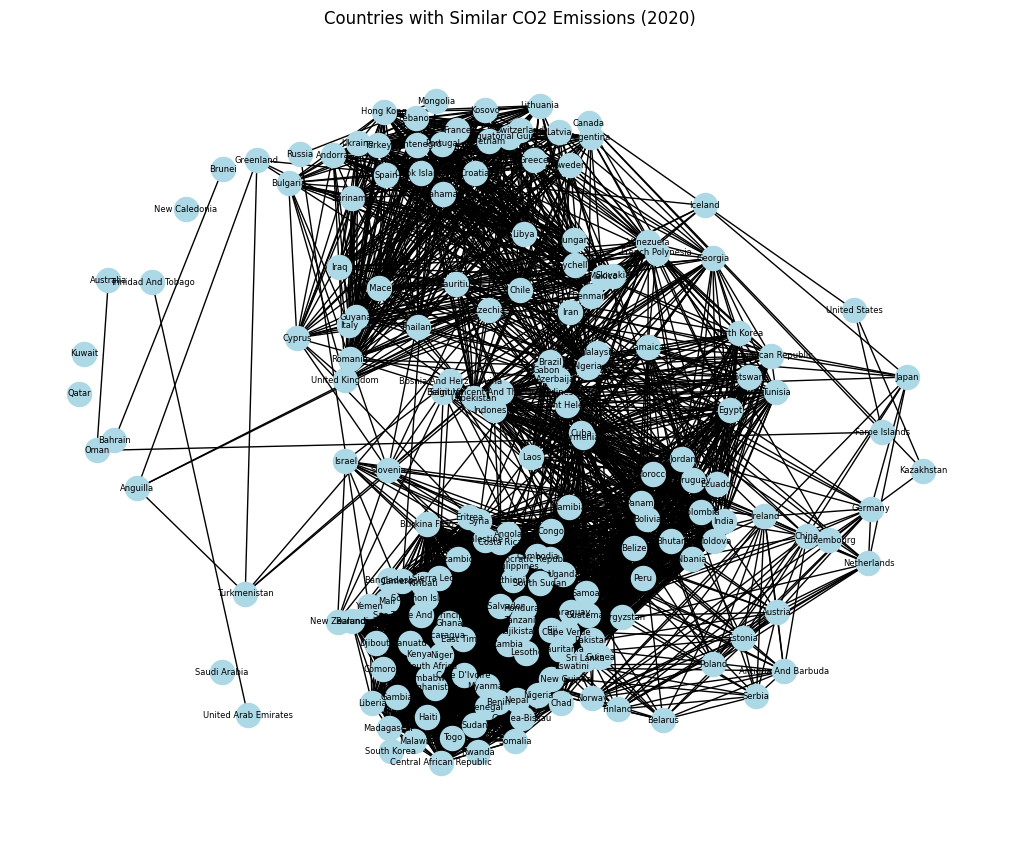

In [32]:
# Plot network graph
plt.figure(figsize=(10, 8))

# Calculate positions for the nodes using a spring layout (visual spacing)
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw the network graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=300, font_size=6)
plt.title("Countries with Similar CO2 Emissions (2020)")
plt.show()

Graph: 182 nodes, 3848 edges


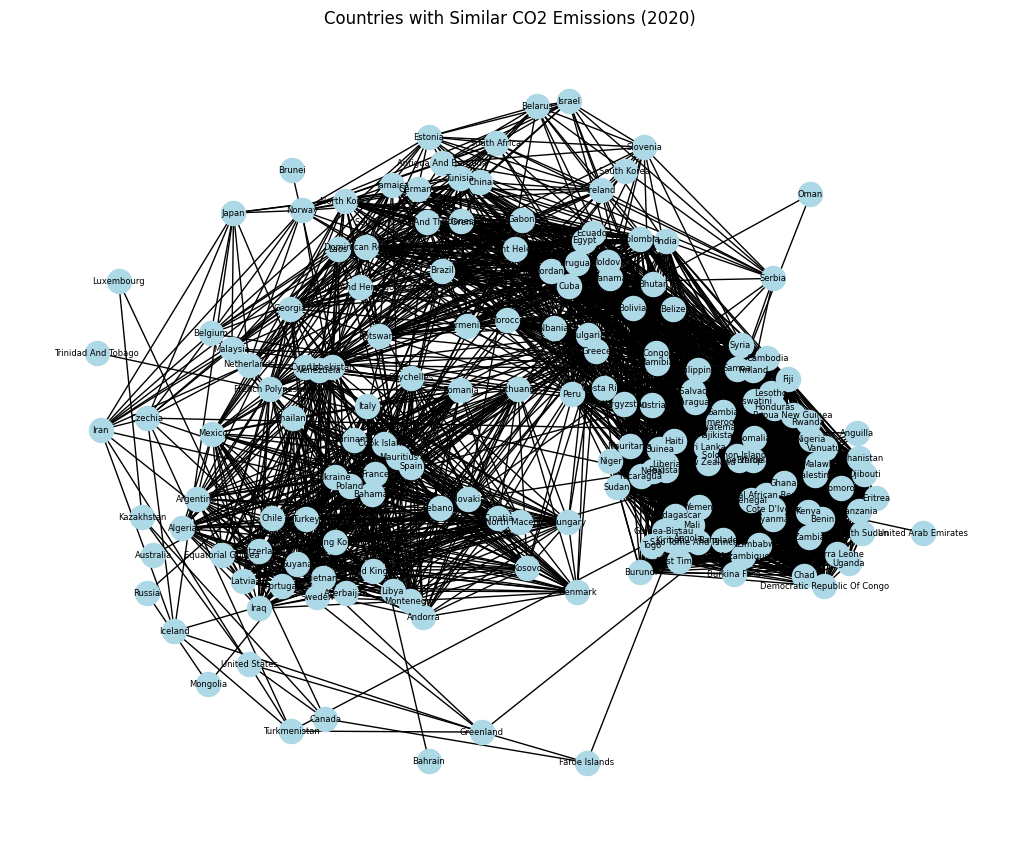

In [58]:
# Build a simpler network graph of countries with similar CO2 emissions in 2020
G = nx.Graph()

# Prepare a list of tuples with (country name, CO2 value)
emissions_2020 = list(
    df_2020[["Country Name", "CO2 Emissions Per Capita"]].itertuples(index=False, name=None)
)

# Loop through all unique pairs
for i in range(len(emissions_2020)):
    for j in range(i + 1, len(emissions_2020)):
        country1, co2_1 = emissions_2020[i]
        country2, co2_2 = emissions_2020[j]
        
        # If emissions difference is less than 1, add an edge
        if abs(co2_1 - co2_2) < 1.0:
            G.add_edge(country1, country2)

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Plot network graph
plt.figure(figsize=(10, 8))

# Calculate positions for the nodes using a spring layout (visual spacing)
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw the network graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=300, font_size=6)
plt.title("Countries with Similar CO2 Emissions (2020)")
plt.show()

In [33]:
# STEP 7: Aggregation & Visualization

# Global temperature by year (using df_with_temps)
global_temp = df_with_temps.groupby("Year")["Annual Temperature Anomaly"].mean()


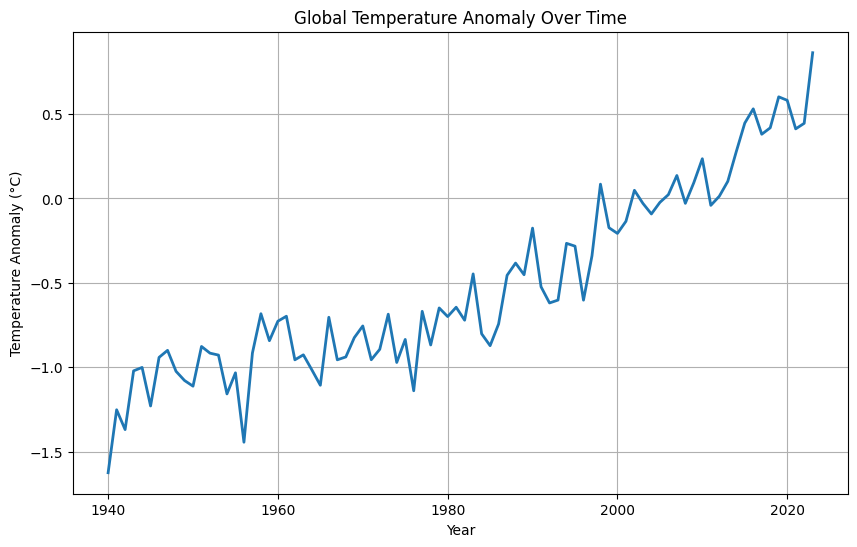

In [34]:
# Visualization 1: Line chart
plt.figure(figsize=(10, 6))
plt.plot(global_temp.index, global_temp.values, linewidth=2)
plt.title("Global Temperature Anomaly Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.show()


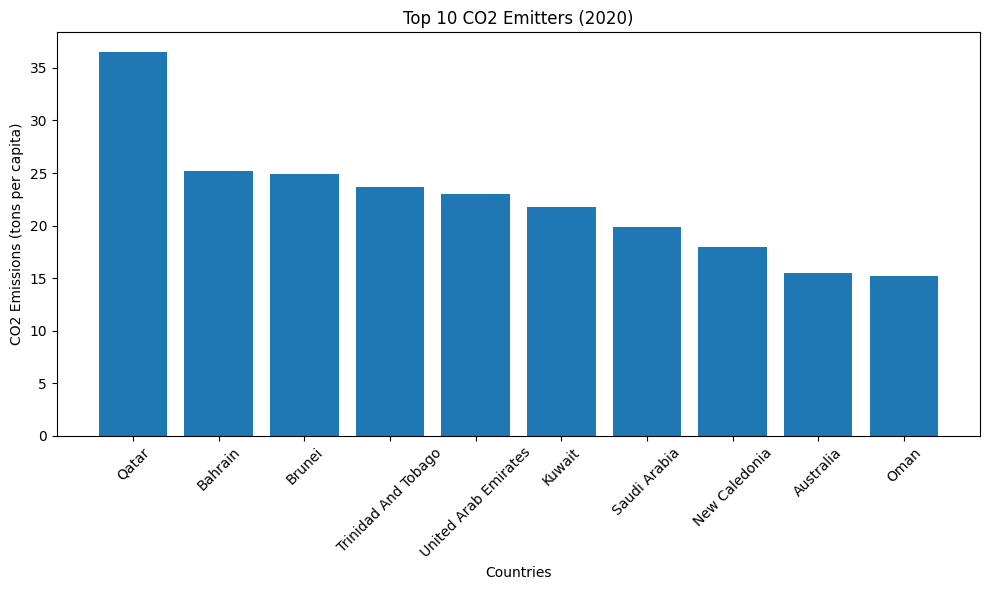

In [35]:
# Visualization 2: Bar chart (top 10 countries 2020)
top_countries = df_2020.nlargest(10, "CO2 Emissions Per Capita")

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_countries)), top_countries["CO2 Emissions Per Capita"])
plt.title("Top 10 CO2 Emitters (2020)")
plt.xlabel("Countries")
plt.ylabel("CO2 Emissions (tons per capita)")
plt.xticks(range(len(top_countries)), top_countries["Country Name"], rotation=45)
plt.tight_layout()
plt.show()

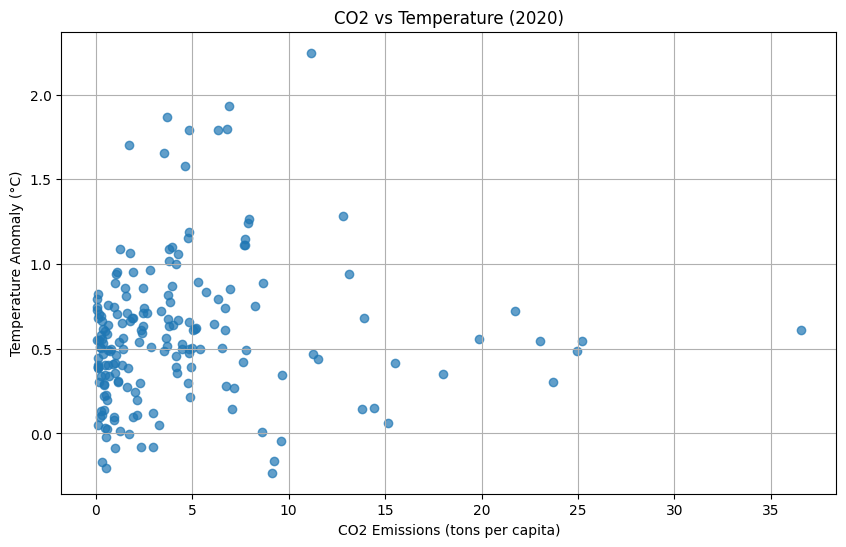

In [59]:
# Visualization 3: Scatter plot (using df_countries for 2020)
plt.figure(figsize=(10, 6))
plt.scatter(df_2020["CO2 Emissions Per Capita"], df_2020["Annual Temperature Anomaly"], alpha=0.7)
plt.title("CO2 vs Temperature (2020)")
plt.xlabel("CO2 Emissions (tons per capita)")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.show()

In [60]:
top_emitters_2020 = df_2020.nlargest(10, "CO2 Emissions Per Capita")
df_major = df[df["Country Name"].isin(major_economies)]

In [61]:
# SUMMARY DATA FOR REPORT

print("\n=== SUMMARY STATISTICS ===")
print("CO2 basic stats (countries only):")
print(df_countries["CO2 Emissions Per Capita"].describe())

print("\nTemperature basic stats (with temps data):")
print(df_with_temps["Annual Temperature Anomaly"].describe())

print(f"\nCorrelation CO2-Temperature: {df_with_temps['CO2 Emissions Per Capita'].corr(df_with_temps['Annual Temperature Anomaly']):.3f}")

print("\nTop 5 emitters 2020:")
print(df_2020.nlargest(5, "CO2 Emissions Per Capita")[["Country Name", "CO2 Emissions Per Capita"]])

print("\nDataframe summaries:")
print(f"Main df: {df.shape}")
print(f"df_with_temps: {df_with_temps.shape}")
print(f"df_regions: {df_regions.shape}")
print(f"df_countries: {df_countries.shape}")

print("\nAnalysis complete!")


=== SUMMARY STATISTICS ===
CO2 basic stats (countries only):
count    14244.000000
mean         4.231716
std          7.846084
min          0.000000
25%          0.325403
50%          1.591767
75%          5.716570
max        364.699400
Name: CO2 Emissions Per Capita, dtype: float64

Temperature basic stats (with temps data):
count    14319.000000
mean        -0.464374
std          0.743285
min         -4.312213
25%         -0.912344
50%         -0.429202
75%          0.029463
max          2.429728
Name: Annual Temperature Anomaly, dtype: float64

Correlation CO2-Temperature: -0.006

Top 5 emitters 2020:
               Country Name  CO2 Emissions Per Capita
19551                 Qatar                 36.564110
2272                Bahrain                 25.215979
3788                 Brunei                 24.939121
23660   Trinidad And Tobago                 23.677786
24466  United Arab Emirates                 23.006842

Dataframe summaries:
Main df: (26182, 5)
df_with_temps: (14319

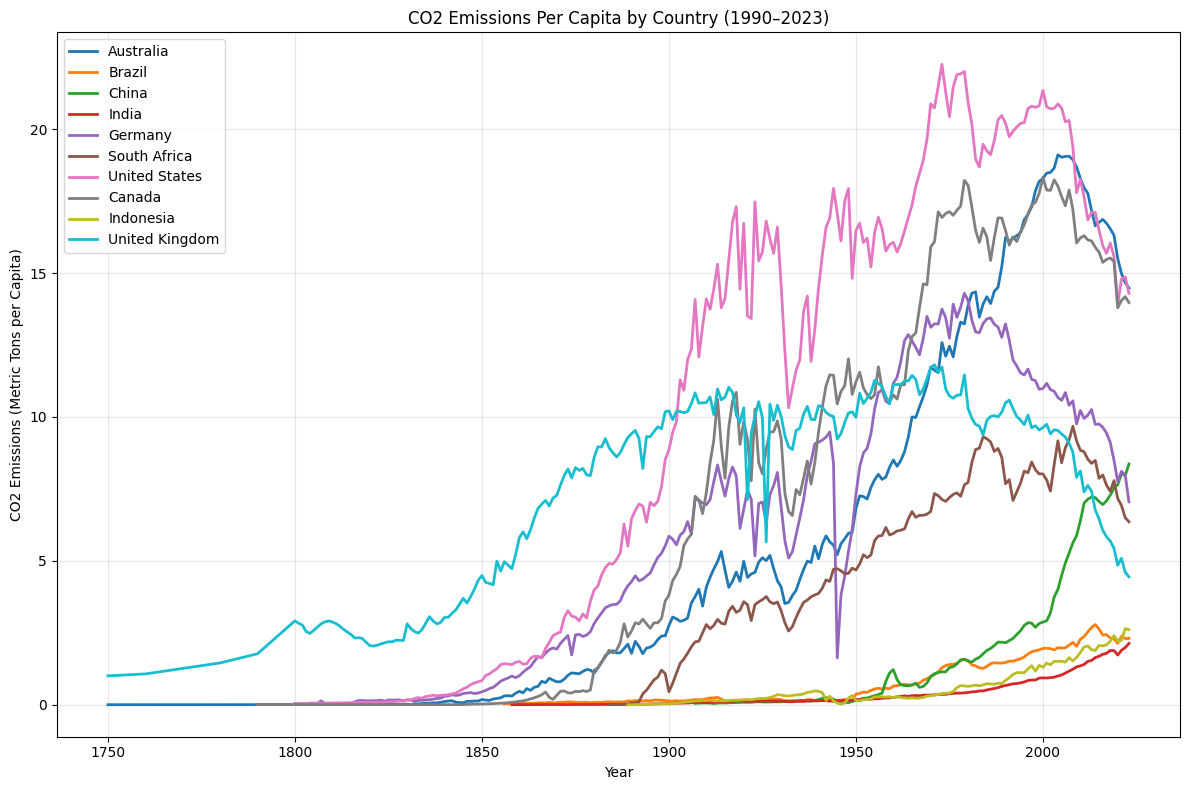

In [62]:
# Create the figure
plt.figure(figsize=(12, 8))

# Plot each country's time series
for country in major_economies:
    country_data = df_major[df_major["Country Name"] == country]
    plt.plot(
        country_data["Year"],
        country_data["CO2 Emissions Per Capita"],
        label=country,
        linewidth=2
    )

# Title and labels
plt.title("CO2 Emissions Per Capita by Country (1990–2023)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Metric Tons per Capita)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [63]:
# Descriptive Statistics for Major Economies

print("Overall CO2 Emissions Statistics:")
print(df_major["CO2 Emissions Per Capita"].describe())

print("\nOverall Temperature Anomaly Statistics:")
print(df_major["Annual Temperature Anomaly"].describe())

print("\nMean CO2 and Temperature by Country:")
mean_by_country = df_major.groupby("Country Name")[["CO2 Emissions Per Capita", "Annual Temperature Anomaly"]].mean()
print(mean_by_country.sort_values("CO2 Emissions Per Capita"))

Overall CO2 Emissions Statistics:
count    1846.000000
mean        5.114369
std         5.766017
min         0.000000
25%         0.195538
50%         2.422330
75%         9.201891
max        22.257160
Name: CO2 Emissions Per Capita, dtype: float64

Overall Temperature Anomaly Statistics:
count    840.000000
mean      -0.456556
std        0.652596
min       -3.066993
25%       -0.906963
50%       -0.445468
75%       -0.035354
max        2.010592
Name: Annual Temperature Anomaly, dtype: float64

Mean CO2 and Temperature by Country:
                CO2 Emissions Per Capita  Annual Temperature Anomaly
Country Name                                                        
India                           0.403189                   -0.305632
Indonesia                       0.616433                   -0.535644
Brazil                          0.723446                   -0.400828
China                           1.866274                   -0.480591
South Africa                    5.113151         

In [64]:
# Correlation Analysis for Major Economies

overall_corr = df_major["CO2 Emissions Per Capita"].corr(df_major["Annual Temperature Anomaly"])
print(f"Overall CO2-Temperature Correlation: {overall_corr:.3f}")

print("\nCorrelation by Country:")
for country in major_economies:
    country_data = df_major[df_major["Country Name"] == country]
    corr = country_data["CO2 Emissions Per Capita"].corr(country_data["Annual Temperature Anomaly"])
    print(f"{country}: {corr:.3f}")

Overall CO2-Temperature Correlation: -0.004

Correlation by Country:
Australia: 0.247
Brazil: 0.710
China: 0.791
India: 0.703
Germany: -0.241
South Africa: 0.407
United States: -0.083
Canada: 0.258
Indonesia: 0.936
United Kingdom: -0.646


In [66]:
# Linear Regression Trend Analysis for Major Economies

from scipy import stats

print("Linear Regression of CO2 Emissions per Year by Country:")
for country in major_economies:
    country_data = df_major[df_major["Country Name"] == country]
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        country_data["Year"],
        country_data["CO2 Emissions Per Capita"]
    )
    print(
        f"{country}: slope = {slope:.4f} tons/year, "
        f"intercept = {intercept:.2f}, "
        f"R² = {r_value**2:.3f}"
    )


# slope = The amount emissions change each year (positive = increase, negative = decrease)
# intercept = Where the trend line crosses the Y-axis 
# R² = How well the trend line matches the real data (1 = perfect fit)

Linear Regression of CO2 Emissions per Year by Country:
Australia: slope = 0.0849 tons/year, intercept = -156.28, R² = 0.837
Brazil: slope = 0.0148 tons/year, intercept = -27.91, R² = 0.790
China: slope = 0.0608 tons/year, intercept = -117.51, R² = 0.732
India: slope = 0.0093 tons/year, intercept = -17.63, R² = 0.685
Germany: slope = 0.0663 tons/year, intercept = -120.85, R² = 0.840
South Africa: slope = 0.0664 tons/year, intercept = -124.60, R² = 0.903
United States: slope = 0.1149 tons/year, intercept = -209.45, R² = 0.875
Canada: slope = 0.0978 tons/year, intercept = -179.81, R² = 0.902
Indonesia: slope = 0.0147 tons/year, intercept = -28.18, R² = 0.728
United Kingdom: slope = 0.0358 tons/year, intercept = -60.77, R² = 0.548


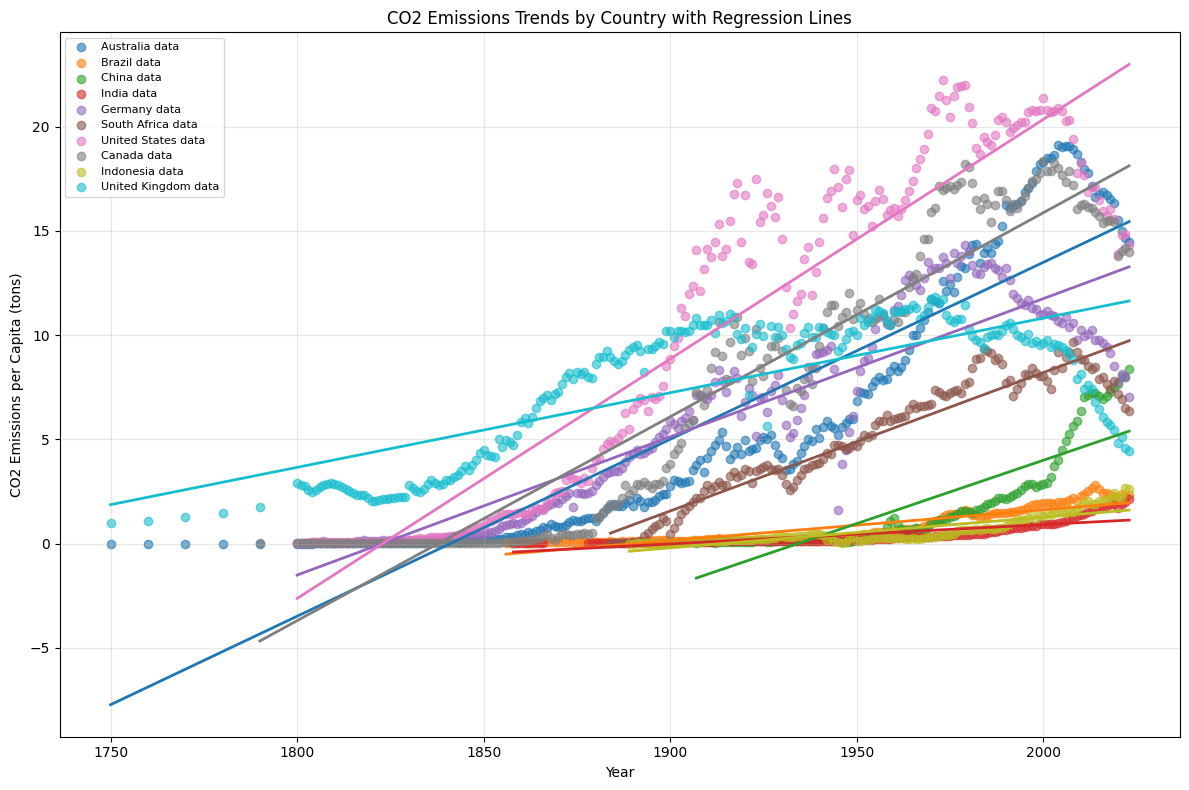

In [67]:
# Visualise the regression lines and actual data points for each country
# This plot helps see the trends and how well the line fits the data

import numpy as np

# Create the figure
plt.figure(figsize=(12, 8))

# Loop over each country to plot
for country in major_economies:
    # Filter the data for this country
    country_data = df_major[df_major["Country Name"] == country]
    
    # Scatter plot of the actual emissions data
    plt.scatter(
        country_data["Year"],
        country_data["CO2 Emissions Per Capita"],
        label=f"{country} data",
        alpha=0.6
    )
    
    # Run the linear regression again to get the slope and intercept
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        country_data["Year"],
        country_data["CO2 Emissions Per Capita"]
    )
    
    # Create x values (years) for the line
    years = np.array(sorted(country_data["Year"].unique()))
    
    # Calculate the predicted y values using the regression line
    trend = intercept + slope * years
    
    # Plot the regression line
    plt.plot(
        years,
        trend,
        linewidth=2
    )

# Add titles and labels to the plot
plt.title("CO2 Emissions Trends by Country with Regression Lines")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions per Capita (tons)")
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()